In [1]:
import numpy as np

## Value Type

We want a class `Value` which can store numbers and support automatic differentiation. We will use this class to represent both the input to our function and the output of our function. We will also use it to represent the intermediate values in our computation graph.

### Utilities

In [2]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot_ng(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

### `Value` class

**Reverse mode AD**

Say, we have a function $f(x) = x^2 + 2x + 1$, and we want to compute the gradient of $f$ at $x=2$. We can do this by hand, but let's use the reverse model AD to do it for us.

Define an adjoint $\bar{v_i} = \frac{\partial{y}}{\partial{v_i}}$

In [3]:
class Value:
    
	def __init__(self, data, _children=(), _op='', label='') -> None:
		self.data = data
		self._prev = set(_children)
		self._op = _op
		self.label = label
		self.grad = 0.
		self._backward = lambda: None

	def __repr__(self) -> str:
		return f"Value(data={self.data:.4f}, grad={self.grad:.4f})"

	def __add__(self, other: 'Value') -> 'Value':
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data + other.data, (self, other), '+')
		def _backward():
			self.grad += 1 * out.grad
			other.grad += 1 * out.grad
		out._backward = _backward

		return out
	
	def __mul__(self, other: 'Value') -> 'Value':
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data * other.data, (self, other), '*')
		def _backward():
			self.grad += other.data * out.grad
			other.grad += self.data * out.grad
		out._backward = _backward

		return out
	
	def __neg__(self, other):
		return self * -1
	
	def __sub__(self, other):
		return self + (-other)
	
	def __rmul__(self, other):
		return self * other
	
	def __radd__(self, other):
		return self + other

	def __pow__(self, other):
		assert isinstance(other, (int, float)), "only int/float are supported for k in Value^k"
		out = Value(self.data**other, (self, ), f'**{other}')
		def _backward():
			self.grad += other * self.data**(other-1) * out.grad
		out._backward = _backward
		
		return out

	def __truediv__(self, other):
		return self * other**-1
	
	def exp(self):
		x = self.data
		e = np.exp(x)

		out = Value(e, (self, ), 'exp')
		def _backward():
			self.grad += e * out.grad
		out._backward = _backward
		
		return out
	
	def tanh(self):
		x = self.data
		t = (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
		
		out = Value(t, (self, ), 'tanh')
		def _backward():
			self.grad += (1 - t**2) * out.grad
		out._backward = _backward

		return out
	
	def backward(self):
		topo = []
		visited = set()
		def build_topo(v):
			if v not in visited:
				visited.add(v)
				for child in v._prev:
					build_topo(child)
				topo.append(v)
		
		build_topo(self)
		
		self.grad = 1.

		for node in reversed(topo):
			node._backward()

In [4]:
# Inputs
x1 = Value(2., label='x1')
x2 = Value(0., label='x2')

# Weights
w1 = Value(-3., label='w1')
w2 = Value(1., label='w2')

# Bias
b = Value(6.9012, label='b')

# Function
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

Initial graph


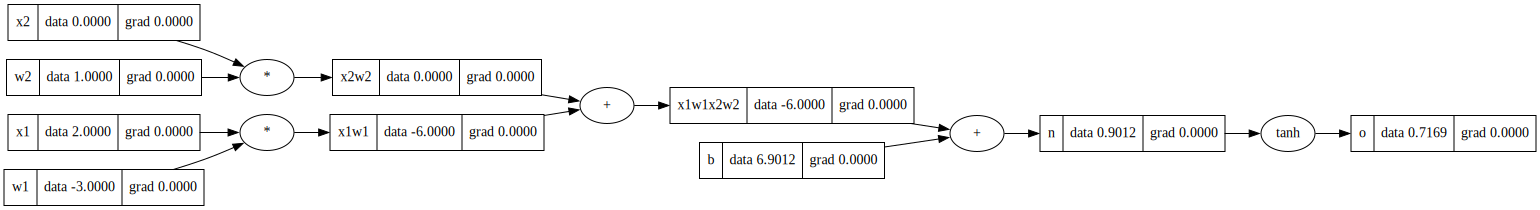

In [5]:
print("Initial graph")
draw_dot(o)

After backward


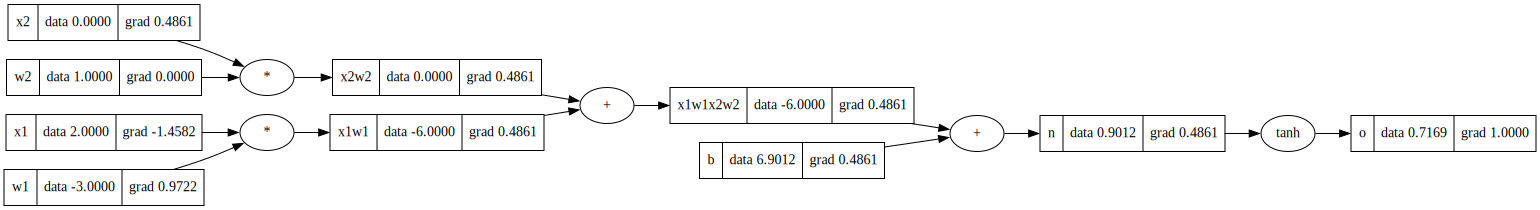

In [6]:
o.backward()
print("After backward")
draw_dot(o)

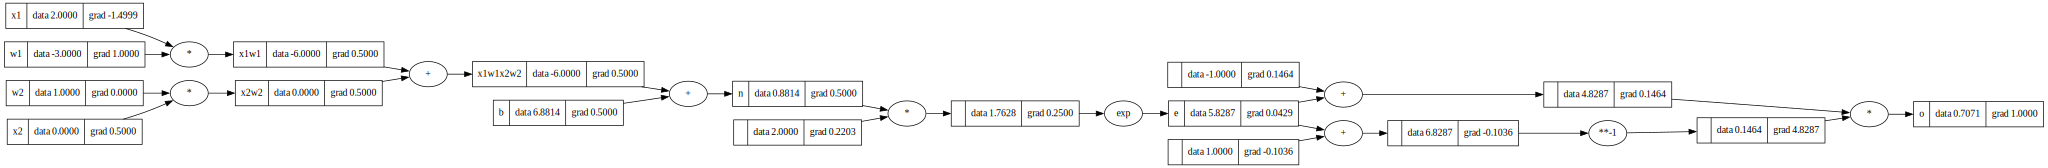

In [7]:
# Let's do something fun

# Inputs
x1 = Value(2., label='x1')
x2 = Value(0., label='x2')

# Weights
w1 = Value(-3., label='w1')
w2 = Value(1., label='w2')

# Bias
b = Value(6.8814, label='b')

# Function
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp(); e.label = 'e'

o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()
draw_dot(o)

## Building nerual networks with *Value*

### Simple `Neuron`, `Layer`, and `MLP` classes

In [8]:
import random

In [9]:
# Neurons
class Neuron:
    
	def __init__(self, n_input, f_out = np.tanh) -> None:
		self.w = [Value(random.uniform(-1, 1)) for _ in range(n_input)]
		self.b = Value(random.uniform(-1, 1))
		self.f_out = f_out

	def __call__(self, x):
		act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
		return self.f_out(act)
	
	def parameters(self):
		return self.w + [self.b]

def neuron_test():
	x = [2., -2.]
	n = Neuron(2)
	print(n(x))
	print(n.parameters())
neuron_test()

Value(data=-0.1858, grad=0.0000)
[Value(data=0.3558, grad=0.0000), Value(data=-0.0138, grad=0.0000), Value(data=-0.9272, grad=0.0000)]


In [10]:
# Layer
class Layer:
	
	def __init__(self, n_input, n_out) -> None:
		self.neurons = [Neuron(n_input) for _ in range(n_out)]
	
	def __call__(self, x):
		outs = [n(x) for n in self.neurons]
		return outs[0] if len(outs)==1 else outs
	
	def parameters(self):
		return [p for neuron in self.neurons for p in neuron.parameters()]
	
def layer_test():
	x = [2., -2.]
	n = Layer(2, 3)
	print(n(x))
	print(n.parameters())
layer_test()

[Value(data=-0.9265, grad=0.0000), Value(data=-0.1411, grad=0.0000), Value(data=0.9003, grad=0.0000)]
[Value(data=-0.2979, grad=0.0000), Value(data=0.9919, grad=0.0000), Value(data=0.9468, grad=0.0000), Value(data=0.6090, grad=0.0000), Value(data=0.6396, grad=0.0000), Value(data=-0.0809, grad=0.0000), Value(data=0.4604, grad=0.0000), Value(data=0.1684, grad=0.0000), Value(data=0.8899, grad=0.0000)]


In [11]:
# MLP
class MLP:
	
	def __init__(self, n_input, n_outs) -> None:
		size = [n_input] + n_outs
		self.layers = [Layer(size[i], size[i+1]) for i in range(len(n_outs))]
	
	def __call__(self, x):
		for layer in self.layers:
			x = layer(x)
		return x
	
	def parameters(self):
		return [p for layer in self.layers for p in layer.parameters()]
	
def MLP_test():
	x = [2., -2., -1]
	n = MLP(2, [4, 4, 1])
	print(n(x))
	print(n.parameters())
MLP_test()

Value(data=0.5073, grad=0.0000)
[Value(data=-0.0500, grad=0.0000), Value(data=-0.3242, grad=0.0000), Value(data=0.0575, grad=0.0000), Value(data=0.2619, grad=0.0000), Value(data=-0.2058, grad=0.0000), Value(data=0.5171, grad=0.0000), Value(data=0.2378, grad=0.0000), Value(data=-0.8036, grad=0.0000), Value(data=0.2553, grad=0.0000), Value(data=0.0574, grad=0.0000), Value(data=0.7603, grad=0.0000), Value(data=0.7922, grad=0.0000), Value(data=-0.1342, grad=0.0000), Value(data=0.7071, grad=0.0000), Value(data=0.3461, grad=0.0000), Value(data=-0.5854, grad=0.0000), Value(data=-0.5587, grad=0.0000), Value(data=-0.6799, grad=0.0000), Value(data=0.3219, grad=0.0000), Value(data=0.9735, grad=0.0000), Value(data=0.5645, grad=0.0000), Value(data=-0.1355, grad=0.0000), Value(data=0.7733, grad=0.0000), Value(data=0.9828, grad=0.0000), Value(data=0.5248, grad=0.0000), Value(data=0.6880, grad=0.0000), Value(data=0.9081, grad=0.0000), Value(data=0.6179, grad=0.0000), Value(data=-0.0913, grad=0.0000), 

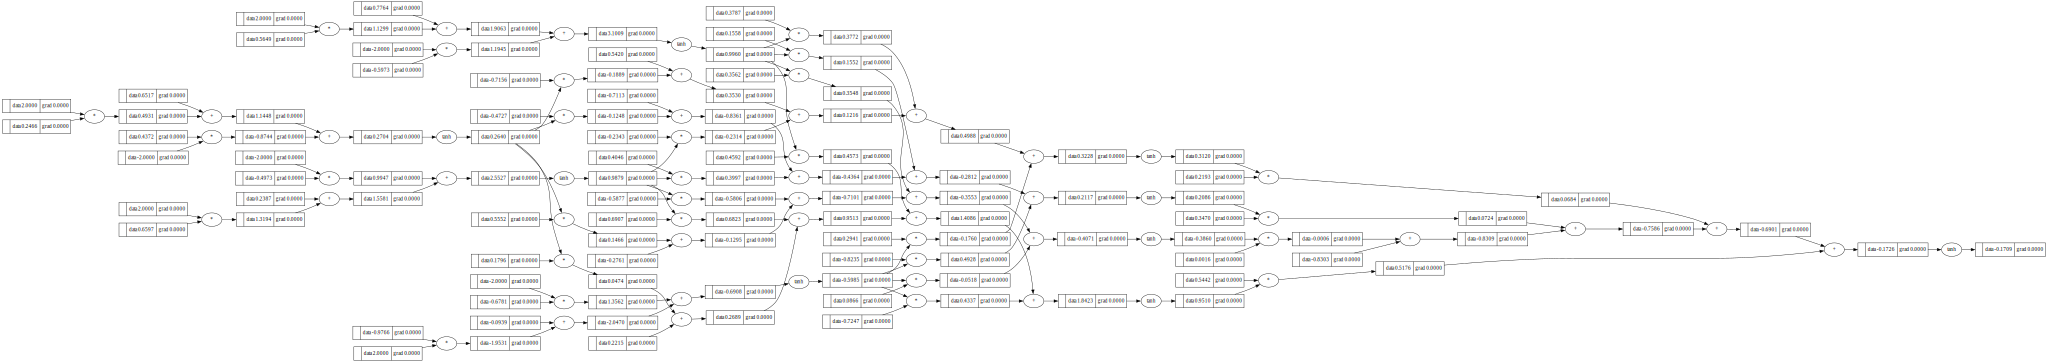

In [12]:
x = [2., -2., -1]
n = MLP(2, [4, 4, 1])
draw_dot(n(x))

### Backprop and optimization

In [83]:
X = [
	[2.0, 3.0, -1.0],
	[3.0, -1.0, 0.5],
	[0.5, 1.0, 1.0],
	[1.0, 1.0, -1.0],
]
Y = [1.0, -1.0, -1.0, 1.0]

In [104]:
n = MLP(3, [4, 4, 1])

In [85]:
y_preds = [n(x) for x in X]
y_preds

[Value(data=-0.6752, grad=0.0000),
 Value(data=-0.6806, grad=0.0000),
 Value(data=-0.6819, grad=0.0000),
 Value(data=-0.8214, grad=0.0000)]

In [86]:
[(y_out - y_true)**2 for y_out, y_true in zip(y_preds, Y)]

[Value(data=2.8064, grad=0.0000),
 Value(data=0.1020, grad=0.0000),
 Value(data=0.1012, grad=0.0000),
 Value(data=3.3175, grad=0.0000)]

Value(data=6.3271, grad=0.0000)


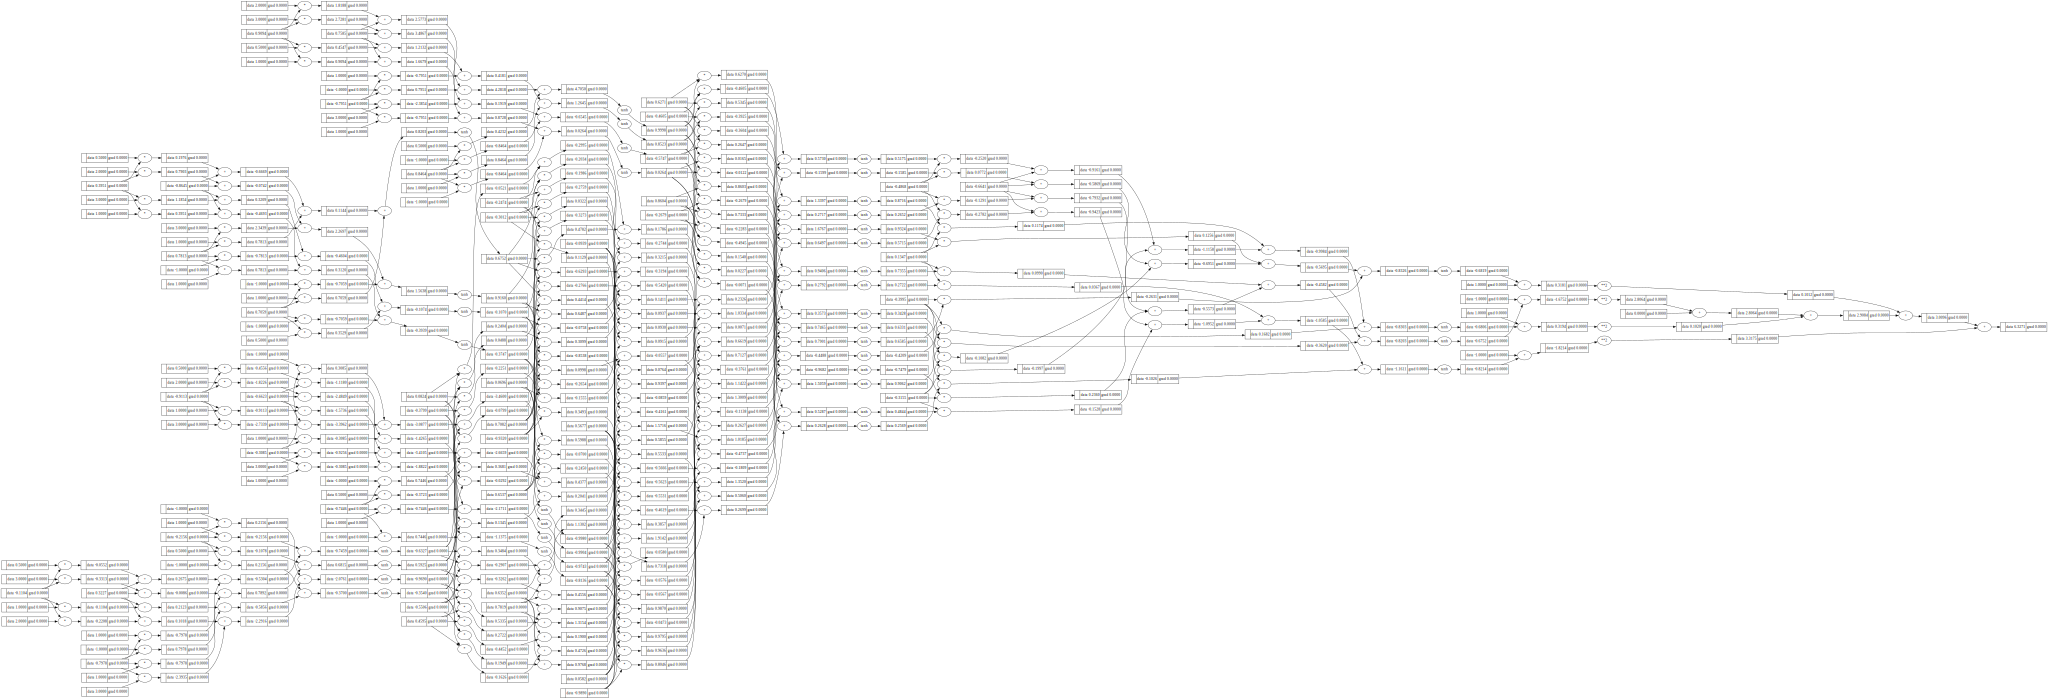

In [87]:
loss = sum((y_out - y_true)**2 for y_out, y_true in zip(y_preds, Y))
print(loss)
draw_dot(loss)

In [19]:
loss.backward()

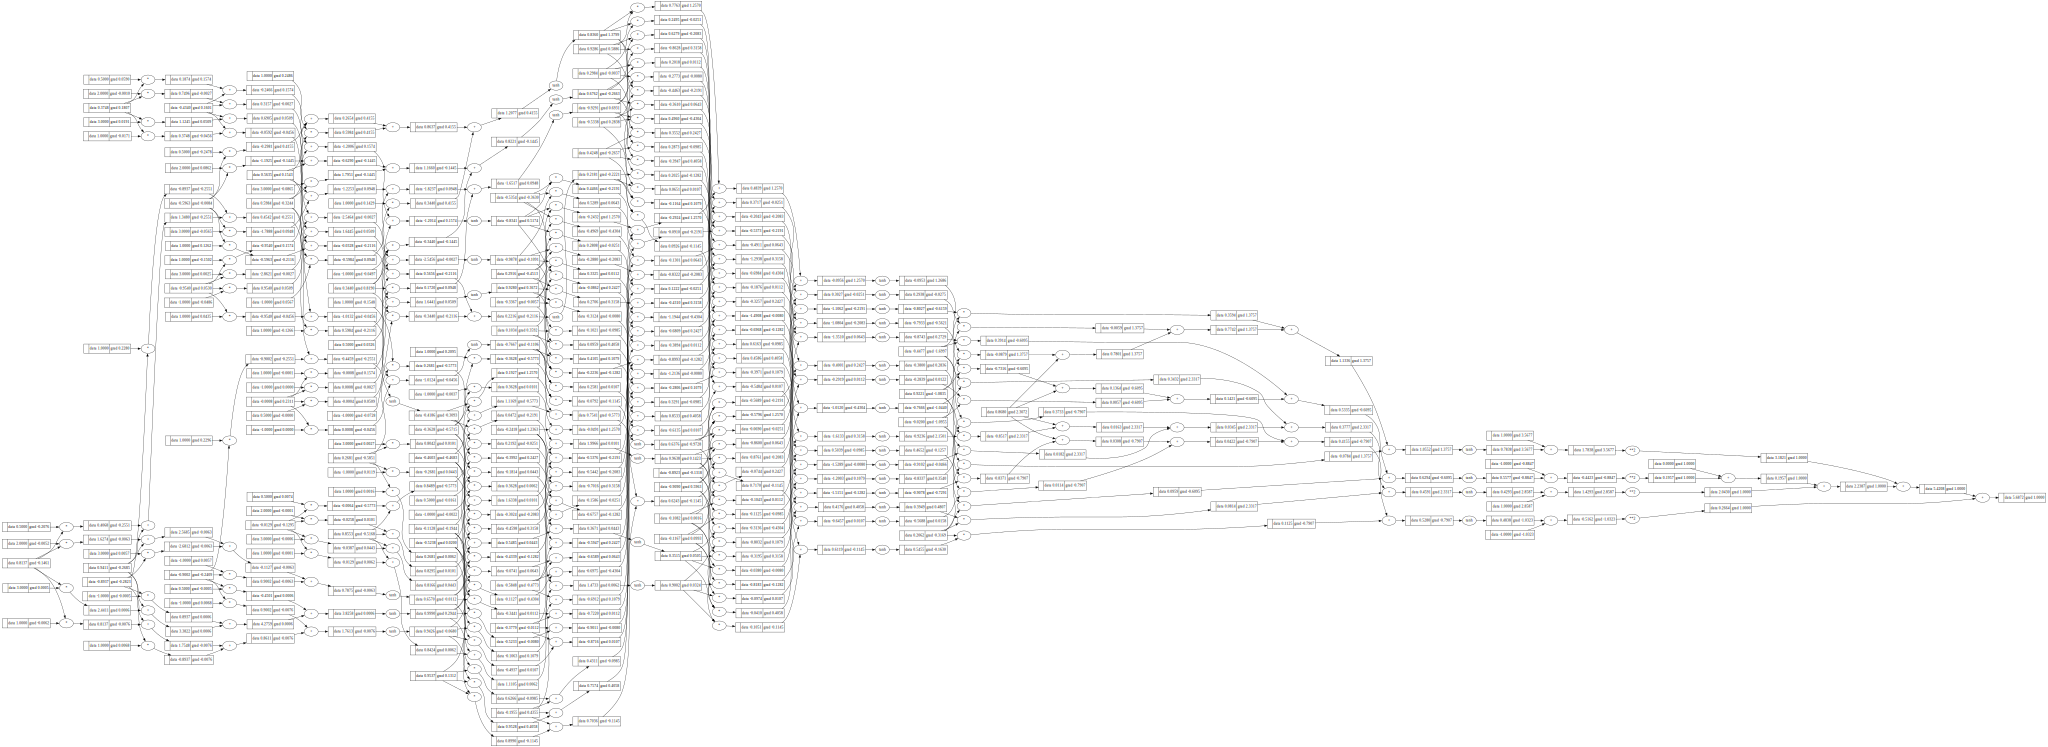

In [20]:
draw_dot(loss)

Optimizing based on the gradient

In [88]:
# Updating the parameters based on gradients
def optimization_step(n, loss, step_size=0.001):
    for p in n.parameters():
        p.data += -step_size * p.grad

A sample optimization loop

In [110]:
num_epochs = 20
n = MLP(3, [4, 4, 1])
for epoch in range(num_epochs):
	# Forward pass
	y_preds = [n(x) for x in X]
	# Compute loss
	loss = sum((y_out - y_true)**2 for y_out, y_true in zip(y_preds, Y))
	print(f"Epoch {epoch} - Loss: {loss.data}")
	# Backward pass
	loss.backward()
	# Optimization step
	optimization_step(n, loss, step_size=0.01)
	# Reset gradients
	for p in n.parameters():
		p = 0.

Epoch 0 - Loss: 4.939395047471683
Epoch 1 - Loss: 4.559092899747433
Epoch 2 - Loss: 4.029699577467456
Epoch 3 - Loss: 3.4039336761630983
Epoch 4 - Loss: 2.568236641441059
Epoch 5 - Loss: 1.5454968380476146
Epoch 6 - Loss: 0.8656602071219838
Epoch 7 - Loss: 0.8072096474026275
Epoch 8 - Loss: 0.8516063404660357
Epoch 9 - Loss: 0.5877769730447403
Epoch 10 - Loss: 0.2048685732653041
Epoch 11 - Loss: 0.04741038087928556
Epoch 12 - Loss: 0.012567841533108748
Epoch 13 - Loss: 0.0046585821616039365
Epoch 14 - Loss: 0.0022854629999393833
Epoch 15 - Loss: 0.0013521358810059992
Epoch 16 - Loss: 0.0009043268179442501
Epoch 17 - Loss: 0.0006584981980451574
Epoch 18 - Loss: 0.0005112613436284982
Epoch 19 - Loss: 0.00041841599983254146


In [112]:
y_preds, Y

([Value(data=0.9938, grad=-0.0124),
  Value(data=-0.9949, grad=0.0102),
  Value(data=-0.9823, grad=0.0354),
  Value(data=0.9936, grad=-0.0128)],
 [1.0, -1.0, -1.0, 1.0])